In [1]:
!python3 -m pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
from torch.nn import init
import matplotlib.pyplot as plt

print(f"Is CUDA available: {torch.cuda.is_available()}")

Is CUDA available: True


In [3]:
# Get Pretrained VGG11 model
def initialize_vgg():
    model = models.vgg11(pretrained=False)

    # Modify classifier for CIFAR10 (32x32 images)
    model.features[0] = nn.Conv2d(
        3, 64, kernel_size=3, padding=1)  # First conv layer
    model.avgpool = nn.AdaptiveAvgPool2d((7, 7))  # For smaller input size
    model.classifier = nn.Sequential(
        nn.Linear(512*7*7, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 10)
    )

    # Initialize weights
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    return model


train_losses = []
test_losses = []
test_accuracies = []


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        # loss = F.nll_loss(output, target)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break

    avg_loss = total_loss / len(train_loader.dataset)
    return avg_loss


def test(model, device, test_loader, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            test_loss += F.cross_entropy(output,
                                         target, reduction='sum').item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset) * 100.

    if verbose:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

    # return for plotting
    return test_loss, accuracy

In [6]:
def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=14, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--no-mps', action='store_true', default=False,
                        help='disables macOS GPU training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args = parser.parse_args([])
    use_cuda = not args.no_cuda and torch.cuda.is_available()
    use_mps = not args.no_mps and torch.backends.mps.is_available()

    torch.manual_seed(args.seed)

    if use_cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    # Change the transform Normalization values for CIFAR10
    transform = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize((0.4914, 0.4822, 0.4465),
        #                     (0.247, 0.243, 0.261))
        transforms.Normalize((0.49, 0.48, 0.45),
                             (0.25, 0.24, 0.26))
    ])

    dataset1 = datasets.CIFAR10('../data', train=True, download=True,
                                transform=transform)
    dataset2 = datasets.CIFAR10('../data', train=False,
                                transform=transform)

    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = initialize_vgg().to(device)
    # Modify the optimizer to use Adadelta
    optimizer = optim.Adam(model.parameters(), lr=2e-4, betas=(0.5, 0.999))

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

    global train_losses, test_losses, test_accuracies
    train_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in range(1, args.epochs + 1):
        # Train and get average loss
        avg_train_loss = train(args, model, device,
                               train_loader, optimizer, epoch)
        train_losses.append(avg_train_loss)

        # Test and collect metrics
        test_loss, accuracy = test(model, device, test_loader)
        test_losses.append(test_loss)
        test_accuracies.append(accuracy)

        scheduler.step()

    plt.figure(figsize=(12, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Plot test accuracy
    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')

    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

    if args.save_model:
        torch.save(model.state_dict(), "cifar_cnn.pt")

100%|██████████| 170M/170M [00:17<00:00, 9.57MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.302226
Train Epoch: 1 [640/50000 (1%)]	Loss: 2.330515
Train Epoch: 1 [1280/50000 (3%)]	Loss: 2.214580
Train Epoch: 1 [1920/50000 (4%)]	Loss: 2.209486
Train Epoch: 1 [2560/50000 (5%)]	Loss: 2.181714
Train Epoch: 1 [3200/50000 (6%)]	Loss: 2.261900
Train Epoch: 1 [3840/50000 (8%)]	Loss: 2.075750
Train Epoch: 1 [4480/50000 (9%)]	Loss: 2.150673
Train Epoch: 1 [5120/50000 (10%)]	Loss: 2.167807
Train Epoch: 1 [5760/50000 (12%)]	Loss: 1.863537
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.016109
Train Epoch: 1 [7040/50000 (14%)]	Loss: 1.934587
Train Epoch: 1 [7680/50000 (15%)]	Loss: 1.825672
Train Epoch: 1 [8320/50000 (17%)]	Loss: 1.860891
Train Epoch: 1 [8960/50000 (18%)]	Loss: 1.920831
Train Epoch: 1 [9600/50000 (19%)]	Loss: 1.764521
Train Epoch: 1 [10240/50000 (20%)]	Loss: 1.719161
Train Epoch: 1 [10880/50000 (22%)]	Loss: 1.770044
Train Epoch: 1 [11520/50000 (23%)]	Loss: 1.759982
Train Epoch: 1 [12160/50000 (24%)]	Loss: 1.827190
Train Epoch: 1 [12800/50000 

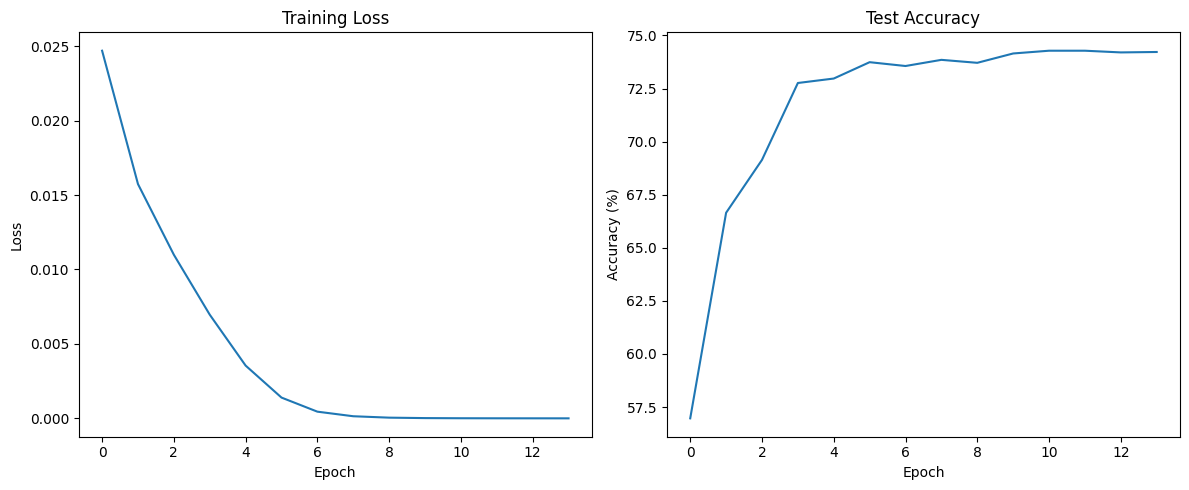

In [7]:
main()